In [1]:
import numpy as np
import pandas as pd
from os import path
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

In [2]:
DATA_DIR = "../../data"

In [4]:
chen_data = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_data.csv"), index_col=0)
chen_data

,Antibody_ID,heavy,light,Y
0,12e8,EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLE...,DIVMTQSQKFMSTSVGDRVSITCKASQNVGTAVAWYQQKPGQSPKL...,0
1,15c8,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0
2,1a0q,EVQLQESDAELVKPGASVKISCKASGYTFTDHVIHWVKQKPEQGLE...,DIELTQSPSSLSASLGGKVTITCKASQDIKKYIGWYQHKPGKQPRL...,1
3,1a14,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,0
4,1a2y,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,0
...,...,...,...,...
2404,6s5a,EVKLLESGGGLVQPGGSLKLSCAASGFDFSRYWMNWVRQAPGKGLE...,QAVVTQESALTTSPGETVTLTCRSSTGAVTTSNYANWVQEKPDHLF...,0
2405,6tyb,EVQLVQSGTEVKRPGESLTISCKTSGYSFSGTWISWVRQMPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQGISTYLAWYQQKPGKAPKL...,0
2406,6u1t,EVQLVESGGGLVKPGGSLKLSCAASGFTFSSYDMSWVRQTPEKRLE...,DIQMTQSPASQSASLGESVTITCLASQTIGTWLAWYQQKPGKSPQL...,0
2407,7fab,AVQLEQSGPGLVRPSQTLSLTCTVSGTSFDDYYWTWVRQPPGRGLE...,ASVLTQPPSVSGAPGQRVTISCTGSSSNIGAGHNVKWYQQLPGTAP...,0


## Load precomputed similrity matrix

In [9]:
heavy_similarity = pd.read_csv(path.join(DATA_DIR, "chen/distances/anarci_similarity_heavy.csv"), index_col=0)
light_similarity = pd.read_csv(path.join(DATA_DIR, "chen/distances/anarci_similarity_light.csv"), index_col=0)
light_similarity = light_similarity.reset_index().drop("Id", axis=1)
heavy_similarity.head()

,0,1,2,3,4,5,6,7,8,9,...,2399,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.0000,0.8580,0.7840,0.7695,0.6567,0.7600,0.8580,0.6860,0.6860,0.8190,...,0.6860,0.6914,0.7450,0.6860,0.6914,0.7110,0.6963,0.7207,0.6914,0.6914
1,0.8580,1.0000,0.8190,0.7890,0.6763,0.7744,0.8870,0.6810,0.6810,0.8580,...,0.7110,0.6963,0.7500,0.6963,0.7060,0.6860,0.6714,0.7160,0.6914,0.6914
2,0.7840,0.8190,1.0000,0.8190,0.6763,0.8140,0.7890,0.7256,0.7256,0.7940,...,0.7160,0.6810,0.7500,0.6914,0.7060,0.6763,0.6763,0.6963,0.6370,0.6665
3,0.7695,0.7890,0.8190,1.0000,0.6567,0.8086,0.7550,0.7010,0.7010,0.7940,...,0.6763,0.7010,0.7600,0.7160,0.7400,0.6714,0.6860,0.6914,0.6567,0.6914
4,0.6567,0.6763,0.6763,0.6567,1.0000,0.6665,0.6665,0.6860,0.6860,0.6763,...,0.6963,0.7256,0.6616,0.6567,0.6567,0.6963,0.6520,0.7060,0.7207,0.7060


In [10]:
heavy_similarity.loc[1921] = [np.nan] * 2407
heavy_similarity.loc[2097] = [np.nan] * 2407

In [11]:
heavy_similarity.insert(1921, "1921", [np.nan] * 2409)
heavy_similarity.insert(2097, "2097", [np.nan] * 2409)

In [12]:
len(heavy_similarity.columns)

2409

In [22]:
similarity = (light_similarity + heavy_similarity) / 2
similarity

,0,1,2,3,4,5,6,7,8,9,...,2399,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.00000,0.77700,0.70350,0.69995,0.65085,0.67350,0.78050,0.66915,0.66915,0.76100,...,0.51700,0.63185,0.65150,0.61850,0.70070,0.60550,0.54015,0.70460,0.61020,0.62840
1,0.77700,1.00000,0.75000,0.73500,0.69315,0.70240,0.76235,0.65570,0.65570,0.74785,...,0.52215,0.65265,0.67200,0.63085,0.69350,0.60750,0.55310,0.71665,0.63920,0.63185
2,0.70350,0.75000,1.00000,0.76100,0.69315,0.68970,0.70600,0.64550,0.64550,0.70850,...,0.52465,0.60500,0.65050,0.62120,0.69350,0.58815,0.55555,0.69965,0.57580,0.60875
3,0.69995,0.73500,0.76100,1.00000,0.66160,0.68700,0.66365,0.65500,0.65500,0.68315,...,0.49390,0.63665,0.65900,0.61900,0.70700,0.59300,0.54950,0.67185,0.58200,0.61370
4,0.65085,0.69315,0.69315,0.66160,1.00000,0.63025,0.64475,0.64000,0.64000,0.64965,...,0.52215,0.64180,0.60255,0.60010,0.67985,0.61990,0.54340,0.76250,0.62135,0.63570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,0.60550,0.60750,0.58815,0.59300,0.61990,0.57125,0.60030,0.58580,0.58215,0.62010,...,0.53210,0.67600,0.64515,0.59425,0.55885,1.00000,0.47705,0.67160,0.59425,0.64800
2405,0.54015,0.55310,0.55555,0.54950,0.54340,0.51600,0.51800,0.50235,0.50235,0.52050,...,0.63985,0.51125,0.52465,0.51610,0.57275,0.47705,1.00000,0.56310,0.48175,0.51360
2406,0.70460,0.71665,0.69965,0.67185,0.76250,0.66085,0.67300,0.65720,0.65720,0.70000,...,0.59545,0.69715,0.62350,0.61500,0.70165,0.67160,0.56310,1.00000,0.59425,0.68700
2407,0.61020,0.63920,0.57580,0.58200,0.62135,0.58095,0.61030,0.55650,0.55650,0.59545,...,0.47925,0.71015,0.69680,0.62065,0.59650,0.59425,0.48175,0.59425,1.00000,0.64020


In [23]:
similarity.loc[1921] = light_similarity.loc[1921]
similarity.loc[2097] = light_similarity.loc[2097]

similarity["1921"] = light_similarity["1921"]
similarity["2097"] = light_similarity["2097"]

## Subset for the remaining Abs

In [31]:
similarity = similarity.loc[chen_data.index]
string_index = [str(num) for num in chen_data.index]
similarity = similarity[string_index]
similarity

,0,1,2,3,4,5,7,8,9,10,...,2398,2400,2401,2402,2403,2404,2405,2406,2407,2408
0,1.00000,0.77700,0.70350,0.69995,0.65085,0.67350,0.66915,0.66915,0.76100,0.71800,...,0.59250,0.63185,0.65150,0.61850,0.70070,0.60550,0.54015,0.70460,0.61020,0.62840
1,0.77700,1.00000,0.75000,0.73500,0.69315,0.70240,0.65570,0.65570,0.74785,0.79775,...,0.59600,0.65265,0.67200,0.63085,0.69350,0.60750,0.55310,0.71665,0.63920,0.63185
2,0.70350,0.75000,1.00000,0.76100,0.69315,0.68970,0.64550,0.64550,0.70850,0.72070,...,0.55975,0.60500,0.65050,0.62120,0.69350,0.58815,0.55555,0.69965,0.57580,0.60875
3,0.69995,0.73500,0.76100,1.00000,0.66160,0.68700,0.65500,0.65500,0.68315,0.71335,...,0.57800,0.63665,0.65900,0.61900,0.70700,0.59300,0.54950,0.67185,0.58200,0.61370
4,0.65085,0.69315,0.69315,0.66160,1.00000,0.63025,0.64000,0.64000,0.64965,0.68375,...,0.62485,0.64180,0.60255,0.60010,0.67985,0.61990,0.54340,0.76250,0.62135,0.63570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,0.60550,0.60750,0.58815,0.59300,0.61990,0.57125,0.58580,0.58215,0.62010,0.61370,...,0.57700,0.67600,0.64515,0.59425,0.55885,1.00000,0.47705,0.67160,0.59425,0.64800
2405,0.54015,0.55310,0.55555,0.54950,0.54340,0.51600,0.50235,0.50235,0.52050,0.52650,...,0.46710,0.51125,0.52465,0.51610,0.57275,0.47705,1.00000,0.56310,0.48175,0.51360
2406,0.70460,0.71665,0.69965,0.67185,0.76250,0.66085,0.65720,0.65720,0.70000,0.67895,...,0.57575,0.69715,0.62350,0.61500,0.70165,0.67160,0.56310,1.00000,0.59425,0.68700
2407,0.61020,0.63920,0.57580,0.58200,0.62135,0.58095,0.55650,0.55650,0.59545,0.60990,...,0.64600,0.71015,0.69680,0.62065,0.59650,0.59425,0.48175,0.59425,1.00000,0.64020


# UMAP reduction

In [26]:
def fit_umap(df, n_components=2, random_state=0, **kwargs):
    reducer = umap.UMAP(n_components=n_components, random_state=random_state, metric='precomputed', **kwargs)
    embedding = reducer.fit_transform(df)
    return reducer, pd.DataFrame(embedding, columns=[f'UMAP-{i+1}' for i in range(n_components)], index=df.index)

In [32]:
reducer, umap_transformed = fit_umap(1-similarity, n_neighbors=10)
umap_transformed.head()

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


,UMAP-1,UMAP-2
0,-0.125489,10.681597
1,3.152811,13.478409
2,2.875287,8.570405
3,2.107078,8.542491
4,0.097480,5.088486


In [36]:
def agglomerative_clustering(distance, linkage='complete', **kwargs):
    clusters = AgglomerativeClustering(linkage=linkage, affinity='precomputed', **kwargs).fit(distance).labels_
    return pd.Series(clusters+1, distance.index)

In [33]:
def plot_clustering(similarity_mat, n_clusters, dist_thresh, umap_coords, linkage="single"):
    clusters = agglomerative_clustering(
        1-similarity_mat, 
        n_clusters=n_clusters, 
        distance_threshold=dist_thresh, 
        linkage=linkage
    )
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.scatterplot(
        data=umap_coords,
        x='UMAP-1',
        y='UMAP-2',
        hue=clusters,
        palette='tab20',
        ax=ax,
        legend=False,
    )
    fig.show()
    return clusters

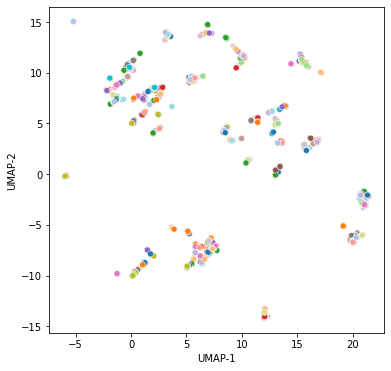

In [37]:
clusters = plot_clustering(similarity, None, 0.05, umap_transformed)

In [39]:
clusters.max()

1225

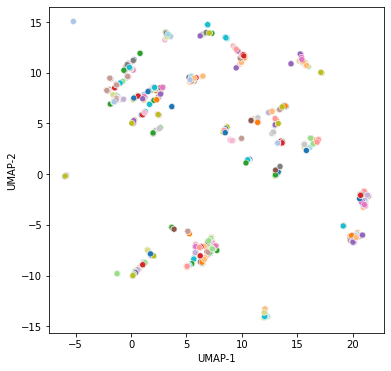

In [40]:
clusters = plot_clustering(similarity, None, 0.1, umap_transformed)

In [41]:
clusters.max()

935